#### Вводные
Эксперимент проводился с 2023-05-01 по 2023-05-07 включительно. Для эксперимента были задействованы 2 и 1 группы.<br>
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.<br>
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

In [32]:
import configparser

import pandas as pd
import seaborn as sns
import numpy as np

import hashlib
import pandahouse

import matplotlib.pyplot as plt


from scipy import stats

%matplotlib inline

In [33]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

### Этап подключения к базе данных и подготовки датафрейма к работе

In [37]:
# Подсоединяемся к нужной базе данных.
# Логины, пароли и прочее в отдельном файле
connection = {
    'host': config.get('clickhouse_connection', 'host'),
    'user': config.get('clickhouse_connection', 'user'),
    'password': config.get('clickhouse_connection', 'password'),
    'database': config.get('clickhouse_connection', 'database')
}

In [38]:
#Посмотрю, что по количетству данных в интересуемом временном отрезке.
q = """
SELECT uniqExact(user_id)
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-05-01' and toDate(time) <= '2023-05-07'
"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,50149


In [39]:
#Выгружаю из базы данных уже сформированный датафрейм для экспериментальных групп 1 и 2
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)


In [40]:
df.describe()

,exp_group,user_id,likes,views,ctr
count,20031.000000,20031.000000,20031.000000,20031.000000,20031.000000
mean,1.496830,75343.140432,13.448954,66.224652,0.215016
std,0.500002,53262.345755,10.865224,45.095939,0.117862
min,1.000000,206.000000,0.000000,1.000000,0.000000
25%,1.000000,22034.000000,6.000000,32.000000,0.117021
50%,1.000000,109234.000000,11.000000,56.000000,0.195122
75%,2.000000,126220.500000,18.000000,90.000000,0.291667
max,2.000000,141164.000000,95.000000,321.000000,0.923077


Для начала построю гистаграмму распределений экспериментальных групп 1 и 2 по CTR и посмотрю глазками, что они из себя представляют.

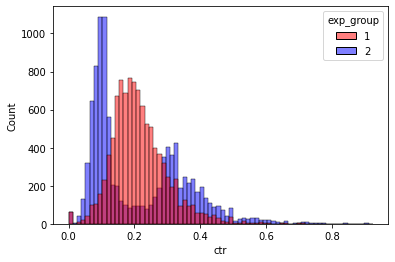

In [41]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Промежуточные наблюдения
Гистограмма показывает, что контрольня группа 1 имеет очертания нормального распределения, тестовую группу 2 к такому рспределению уже не отнести так как проглядывается длинный хвост данных вправо и отчетливо видно выброс на значениях 0.1 и распределение является бимодальным. Даже грубыми прикидками не сказать, имеются ли значимые различия по CTR.

### Выбор метода анализа
Теперь последовательно буду прогонять наши данные через различные методы и посмотрю, что они мне покажут. 

# t-тест (Классический и Уэлча)

In [44]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
               df[df.exp_group == 2].ctr,
               equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [45]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
               df[df.exp_group == 2].ctr,
               equal_var=True)

Ttest_indResult(statistic=0.7116545895251319, pvalue=0.4766869824114077)

### Результат
Т-тест значимых результатов не показал. p_value = 0.47, нас бы устроило не больше 0.05 включительно.

# Тест Манна-Уитни

In [46]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

### Результат
А непараметрический метод показал наличие статистических различий при значениях p_value = 6.03*e-56. 


# t-тест на сглаженном ctr (α=5)

/tmp/ipykernel_238/2446993309.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.ctr,


Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

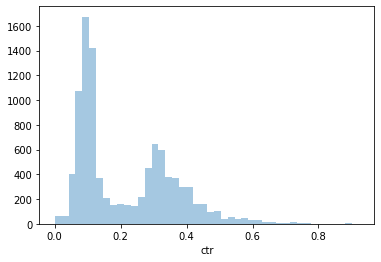

In [47]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 2].copy()
sns.distplot(group1.ctr, 
             kde = False),

stats.ttest_ind(df[df.exp_group == 1].ctr,
               df[df.exp_group == 2].ctr,
               equal_var=False)

График вверху отображает распределение CTR для тестовой группы -"двухгорбое" и совершенно ненормальное распределние. Посмотрю, как проявит себя сглаженный CTR на таком распределении.

/tmp/ipykernel_238/1515278661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.smothed_ctr,


<Axes: xlabel='smothed_ctr'>

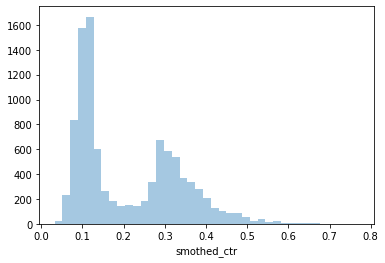

In [48]:
# Применю функцию сглаживания CTR для тестовой группы.
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)

### Результат
Как видно сглаживание CTR не оказало сильного влияния но форму распределения (при значении гиперпараметра ALPHA = 5). Увеличение значения гиперпараметра также ощутимых изменений не дает.

# Пуассоновский бутстреп

<Axes: ylabel='Count'>

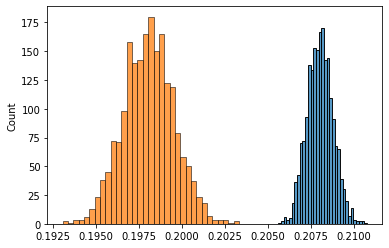

In [65]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

### Результат
Пуассоновский бутстреп показывает, что разница между группами есть, так как распределения не пересекаются. Синее распределение - это контрольная группа, значит тестовая группа статистически значимо ухудшила показатели CTR.<br>
Посмотрим как сильно.

<Axes: ylabel='Count'>

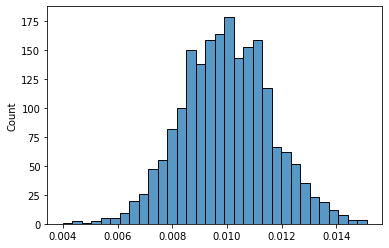

In [66]:
#Разница между глобальными CTR

sns.histplot(ctr1 - ctr2)

### Промежуточные выводы после бутстрапа
Вычитая созданные бутстрепом распределения, получаю, что в среднем различия по CTR между группами 1 и 2 - 1% в пользу <b> группы контроля.

# Бакетное преобразование

In [67]:
#Подготавливаю запрос для извлечения датафрейма нужной конфигурации

q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)


# t-тест поверх бакетного преобразования

In [68]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

# Тест Манна-Уитни поверх бакетного преобразования

In [69]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

### Результаты на бакетированных данных
И t-тест и тест Манна-Уитни после бакетного преобразования показали значимые различия между группами.

<Axes: xlabel='bucket_ctr', ylabel='Count'>

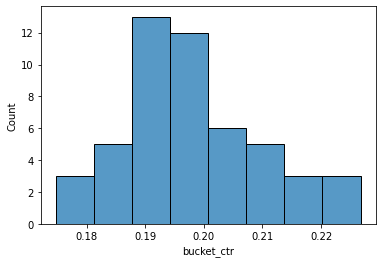

In [70]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)


Из графика выше видно, как бакетное преобразование скорректировала бимодальное  распределение. Идеально нормальным оно не стало, но приблизилось к нему.

# Выводы
#### Примененные методы анализа  показали следующие результаты:
1. T-тест и Т-тест Уэлча не нашли различий между выборками при P_value = 0.48.<br>Т-тест Уэлча применил для сравнения результатов между классической версией. Такие результы возможны p_value при сильно ненормальном распределении как у тестовой группы вместе с отностительно небольшой выборокой. Достаточно большая выборка может выправить ситуацию с бимодальным распределением, но не тут - мало данных для "выправления" такого распределения и будет "дорого стоить". Есть способы "подешевле".
2. Непараметрический метод Манна-Уитни выявил статистические различия при P_value = 6.03e-56. Его способность в первую очередь не обращать внимание на форму распределения здесь уместна как никогда. При этом данные (мало одинаковых значений в распределениях), с которыми работает метод повышают его точность.
3. Способ, при котором мы сглаживаем распределение CTR не дал эффекта вне зависимости от выбранного гиперпараметра. Распределение CTR тестовой группы слишком "сложное" для данного метода.
4. Пуассоновский бутстреп показал отличные результаты, а именно:
    а) принцип работы метода позволил выделить два практически нормальных распределения и показать в каких диапазонах CTR находится каждое из них, при этом показав, что они не пересекаются вообще, что дает нам статистически значемый результат об их различии.
    б) Позволил визуально отобразить, каким является среднее значение резличия между тестовой и контрольной группой, а именно 1% CTR (в диапазоне от 0.04% до 1.6%) и самое главного показал, какая группа больше.
5. Бакетное преобразование с использованием Т-теста и теста Манна-Уитни также показало отличные результаты, теперь особенно для T-теста, так как нормализация распределения бакетами позволила ему нормально отработать на преобразованной выборке и найти стат. значимые различия. Манн-Уитни отработал штатно - для него особо ничего не поменялось.

#### Потенциальная ситуация, приведшая к такому результату
Возможная причина формирования в тестовой группы подобного распределения может заключаться в ошибке алгоритма рекомендаций постов. На самом первом графике видно, что для какой то группы аудитории CTR (диапозон 0.3 - 0.6) действительно вырос, а тот костяк аудитории который был в районе CTR=0.2 перешел в район CTR=0.1.

##### Гипотетический пример такого поведения распределения

Есть мобильное приложение(новостная лента), оно активно используется на территории страны N и распрастранено только там.
На территории страны работают два мобильных оператора, где доля каждого примерно 50/50. На период проведения A/B теста с 2023-05-01 по 2023-05-07 один из операторов решил провести модернизацию мобильных сетей и делал он это неправильно, поэтому на период проведения работ доступная скорость интернета для его пользователей упала до уровня GPRS. Именно для этих пользователей CTR "перетек" с 0.2 на 0.1 и меньше. Тем временем пользователи второго оператора прочувствовали новый алгортим в действии, что и отразилось на повышении CTR (видно на графике - диапазон 0.3 - 0.6). 
    
### Бизнес-выводы и рекомендации:
1. Бизнесу - одназначно не раскатывать, CTR упал в среднем на 1%
2. Команде, занимающейся алгоритмом необходимо найти реальную причину такого распределения и вновь проводить тест на пользователях, ранее незадействованных в этом эксперименте, если таких нет - проводить тест не ранее чем через 6-8 недель.

